In this tutorial, we will explore the basic concepts of accessing scroll data, processing them in a numpy-fashion, and also how to extract a small portion of the surface of the scroll. We call this last step "segmentation".

### Steps Overview:
1. **Access the Scroll**:
   - Start by downloading the necessary scroll data.

2. **Focus on a Smaller Region of the Volume**:
   - Zoom in on a specific section of the data.

3. **Plot a Histogram of Intensity Values**:
   - Perform simple numpy operations on a small scroll chunk to create a histogram of intensity values.

##### Advanced (skip if you are not interested in surface segmentation)
4. **Segmentation Fast Tutorial**:
   - Demonstrate a simple proof-of-concept for segmenting a small portion of the scroll's surface. Note that segmenting a full scroll is much more complicated.

   a. **Denoise**
   
   b. **Surface Detection**
   
   c. **Layer Extraction**
   
   d. **Flattening**
   
   e. **Meshing**

### Getting Started:
#### 1. Access the scroll
First, we need to download the Vesuvius package, which will help us quickly fetch the scroll data from the repository.

---



In [1]:
#!pip install vesuvius
#!vesuvius.accept_terms --yes;

In [2]:
import vesuvius
from vesuvius import Volume
from matplotlib import pyplot as plt

Great! Here's the next step for initializing a `Volume` object using Scroll 1. The canonical volume was scanned at 54keV and 7.91um resolution.

This code snippet demonstrates how to install the Vesuvius package, import the `Volume` class. We can both load the canonical volume by just prompting "scroll1" or by specifying the scan metadata.

In [3]:
scroll = Volume("Scroll1", verbose=True)
#scroll = Volume("scroll", 1, 54, 7.91) this would also work

Data with original resolution: 7.91 um, subvolume idx: 0, shape: (14376, 7888, 8096)
Contains also data with scaled resolution: 15.82 um, subvolume idx: 1, shape: (7188, 3944, 4048)
Contains also data with scaled resolution: 31.64 um, subvolume idx: 2, shape: (3594, 1972, 2024)
Contains also data with scaled resolution: 63.28 um, subvolume idx: 3, shape: (1797, 986, 1012)
Contains also data with scaled resolution: 126.56 um, subvolume idx: 4, shape: (899, 493, 506)
Contains also data with scaled resolution: 253.12 um, subvolume idx: 5, shape: (450, 247, 253)


scroll is a `Volume` object that points to the Scroll 1 volume scanned at 54keV and 7.91um on our online repository. It contains the volume scanned at the original resolution and subsampled versions of it. We can access to the data exactly as a numpy array. When we provide just 3 indices we will access automatically to the data in the original volume. If we provide 4 indices we are going to access to the subsampled volumes. The subsampled volume is specified by the fourth index. The first three indices will point to a smaller region of the volume. The reference frame will be indexed with the following convention: z, y, x.

#### 2. Focus on a smaller region
Let's focus on a smaller region, for instance let's focus on a single slice (z = 1000)

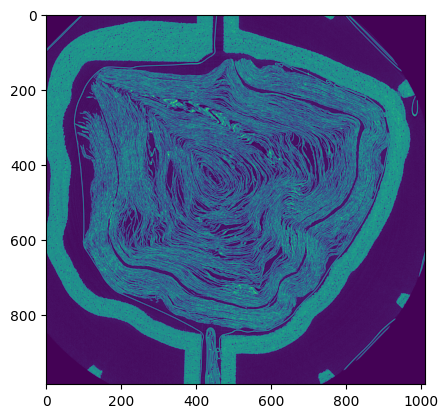

In [4]:
# visualizing a full slice of the volume downsampled at 63.28 um
plt.imshow(scroll[1000,:,:,3])

Let us visualize multiple z-slices

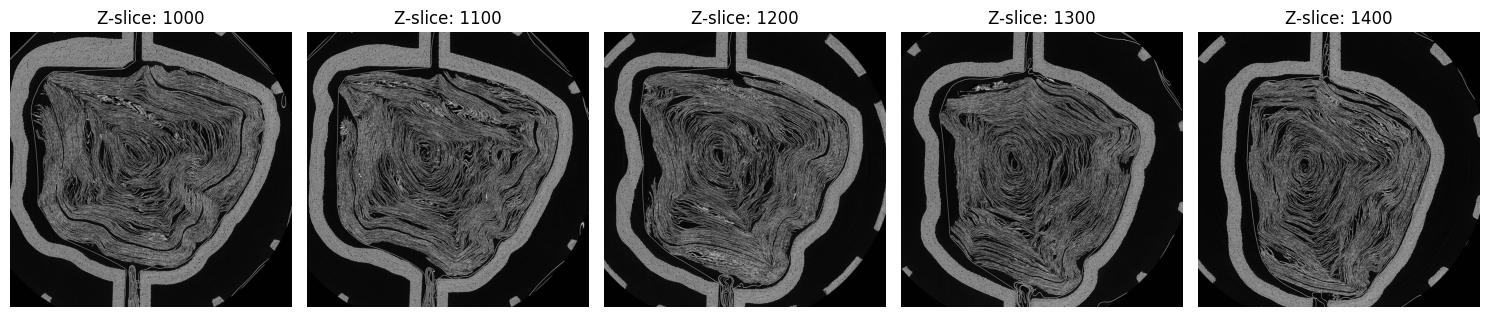

In [8]:
# Set the starting slice and the number of slices to display
slice_index = 1000
num_slices = 5  # Number of slices to display side by side

# Create a figure with subplots
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

# Plot each slice side by side
for i in range(num_slices):
    current_slice = slice_index + 100*i
    axes[i].imshow(scroll[current_slice, :, :, 3], cmap='gray')
    axes[i].set_title(f'Z-slice: {current_slice}')
    axes[i].axis('off')  # Hide axes

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

Let's do the same for a sagittal view!

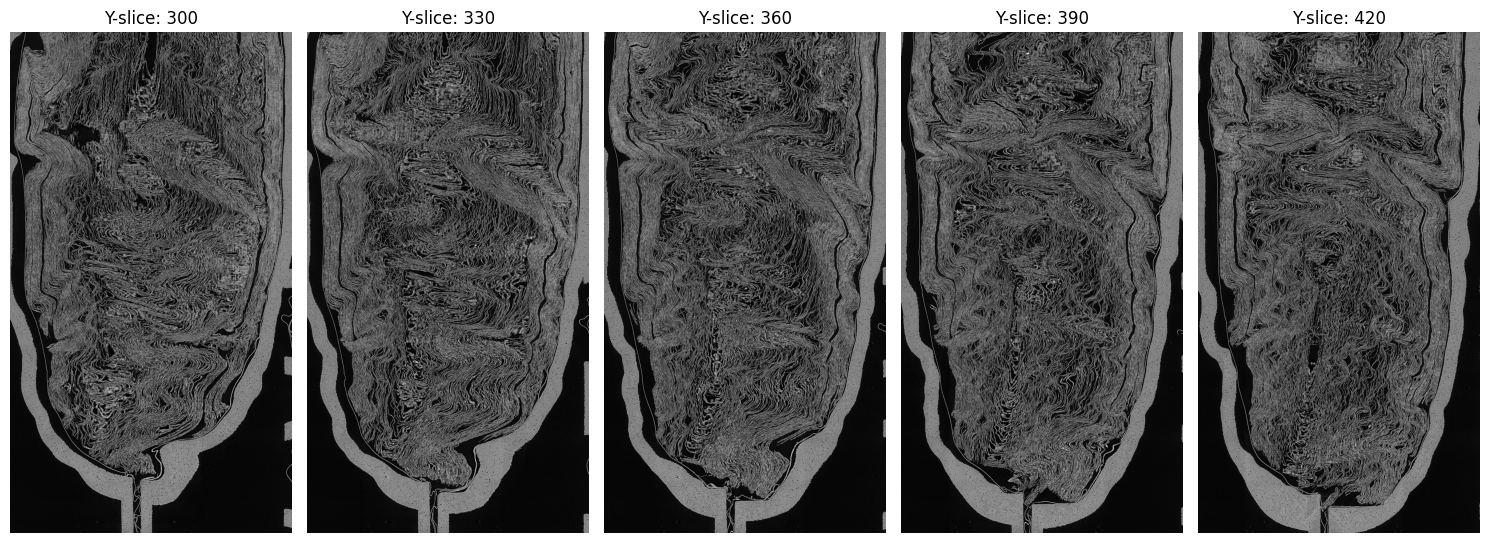

In [13]:
# Plot each slice side by side
# Create a figure with subplots
fig, axes = plt.subplots(1, num_slices, figsize=(15, 10))

slice_index = 300
for i in range(num_slices):
    current_slice = slice_index + 30*i
    axes[i].imshow(scroll[:, current_slice, :, 3], cmap='gray')
    axes[i].set_title(f'Y-slice: {current_slice}')
    axes[i].axis('off')  # Hide axes

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

#### What files are available on the data repository?
We can also check which files are available with the following command

In [14]:
file_dict = vesuvius.list_files()

In [15]:
print(file_dict)

{'1': {'54': {'7.91': {'segments': {'20230503225234': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230503225234.zarr/', '20230504093154': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504093154.zarr/', '20230504094316': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504094316.zarr/', '20230504125349': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504125349.zarr/', '20230504171956': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504171956.zarr/', '20230504223647': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504223647.zarr/', '20230504225948': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504225948.zarr/', '20230504231922': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230504231922.zarr/', '20230505093556': 'https://dl.ash2txt.org/other/dev/scrolls/1/segments/54keV_7.91um/20230505093556.zarr/', '

#### 3. Plotting a histogram of intensity values


In [16]:
import numpy as np

In [17]:
scroll= Volume("Scroll1", normalize=True) # normalize True activates normalization, values in {0, ..., 255} are mapped to [0,1]

In [18]:
scroll.meta() # print the available subvolumes

Data with original resolution: 7.91 um, subvolume idx: 0, shape: (14376, 7888, 8096)
Contains also data with scaled resolution: 15.82 um, subvolume idx: 1, shape: (7188, 3944, 4048)
Contains also data with scaled resolution: 31.64 um, subvolume idx: 2, shape: (3594, 1972, 2024)
Contains also data with scaled resolution: 63.28 um, subvolume idx: 3, shape: (1797, 986, 1012)
Contains also data with scaled resolution: 126.56 um, subvolume idx: 4, shape: (899, 493, 506)
Contains also data with scaled resolution: 253.12 um, subvolume idx: 5, shape: (450, 247, 253)


In [19]:
hist = np.histogram(scroll[1800:2000,1000:1200,1000:1200,2])

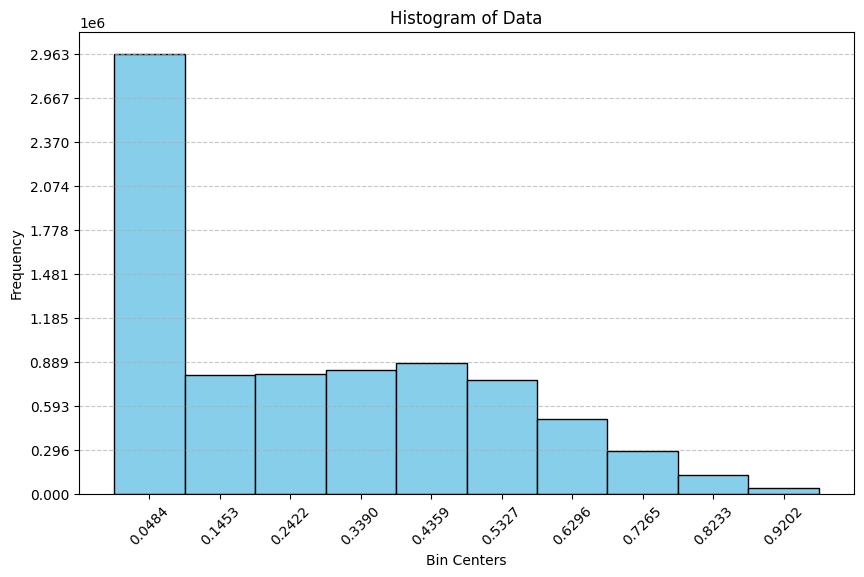

In [20]:
# Calculate the bin centers
bin_centers = (hist[1][1:] + hist[1][:-1]) / 2

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist[0], width=(hist[1][1] - hist[1][0]), color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Bin Centers')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize tick marks
plt.xticks(bin_centers, rotation=45)
plt.yticks(range(0, max(hist[0]) + 1, max(hist[0]) // 10))

# Show the plot
plt.show()

What does this plot mean?? In a recostructed volumetric image from an X-ray CT scan the intensity of every voxel is proportional to the density of the material.
We normalized the intensity in the range from 0 to 1.
The most frequent values are close to zero, meaning that air (or void) voxels are the most abundant in the volume chunk we selected.

What happens if we select another chunk, maybe around the center?

Try for yourself!

In [ ]:
Z_START = 
Z_END = 
Y_START =
Y_END = 
X_START = 
X_END = 
VOLUME_INDEX =
hist = np.histogram(scroll[Z_START:Z_END,Y_START:Y_END,X_START:X_END,VOLUME_INDEX])
# Calculate the bin centers
bin_centers = (hist[1][1:] + hist[1][:-1]) / 2

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist[0], width=(hist[1][1] - hist[1][0]), color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Bin Centers')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize tick marks
plt.xticks(bin_centers, rotation=45)
plt.yticks(range(0, max(hist[0]) + 1, max(hist[0]) // 10))

# Show the plot
plt.show()

#### Advanced (skip if you are not interested in surface segmentation)
#### 4. Segmentation Fast Tutorial

Let us just plot a smaller portion of slice 7000 at the canonical resolution.

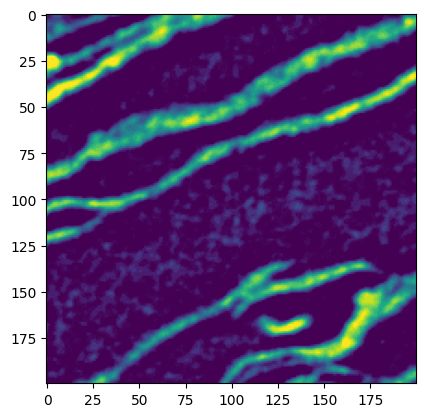

In [22]:
plt.imshow(scroll[7000,4600:4800,4000:4200])

We are going to get our hands dirty and extract a little piece of surface from this data. We will apply the following steps:

a. **Denoise**
b. **Surface Detection**
c. **Layer Extraction**
d. **Flattening**
e. **Meshing**


**a. Denoise**
We are going to denoise the data to make it more easily manipulable by the surface detection in the next step. We have to do it because the surface detection leverages approximations of the gradient (local difference in voxel intensity) that can be disturbed by noise.
:


In [23]:
!pip install scikit-image PyWavelets
from skimage.restoration import estimate_sigma, denoise_nl_means

In [24]:
# Download data chunk into numpy array
chunk = scroll[7000:7100,4600:4800,4000:4200]

In [25]:
# Estimate variance in the chunk
sigma = estimate_sigma(chunk)
# Denoise with non-local means using the extracted sigma
chunk = denoise_nl_means(chunk, patch_size=7, patch_distance=3, sigma=sigma, h=0.03)

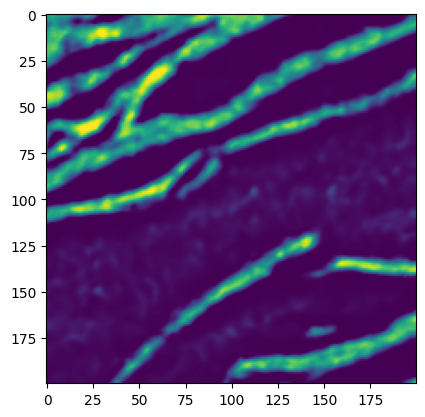

In [26]:
plt.imshow(chunk[20,:,:])

**b. Surface detection**
Let's define an algorithm to detect the surface. What we are going to use will evaluate the gradient and the hessian at every voxel in the denoised chunk and select only those voxels that have a gradient magnitude higher than a threshold AND the determinant of the Hessian lower than another threshold. This helps focusing on the surface and neglecting blobs. Later, we perform Non-Maximum Suppression to make the extracted surface thin.

In [27]:
import numpy as np
from scipy.ndimage import convolve, map_coordinates

def divide_nonzero(array1, array2):
    precision = array1.dtype
    denominator = np.copy(array2)
    denominator[denominator == 0] = np.finfo(precision).tiny
    return np.divide(array1, denominator)

def calculate_det(a,b,c,d,e,f):
    det = np.abs(a*(b*c-e**2)-d*(d*c-e*f)+f*(d*e-b*f))
    return det

def normalize_gradient(a,b):
    return a/b

def grad_and_det(volume, precision):
    a = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    b = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    c = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    d = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    e = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)
    f = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=precision)

    # Using Pavel Holoborodko's derivative
    pavel_1d = np.array([2,1,-16,-27,0,27,16,-1,-2], dtype=precision)  # Derivative approximation
    pavel_1d_smooth = np.array([1, 4, 6, 4, 1], dtype=precision)  # Smoothing
    pavel_1d_2nd = np.array([-7,12,52,-12,-90,-12,52,12,-7], dtype=precision)

    # Create 3D kernels by outer products and normalization
    kz = np.outer(np.outer(pavel_1d, pavel_1d_smooth), pavel_1d_smooth).reshape(9, 5, 5)/ (96*16*16)
    ky = np.outer(np.outer(pavel_1d_smooth, pavel_1d), pavel_1d_smooth).reshape(5, 9, 5)/ (96*16*16)
    kx = np.outer(pavel_1d_smooth, np.outer(pavel_1d_smooth, pavel_1d)).reshape(5, 5, 9)/ (96*16*16)
    kzz = np.outer(np.outer(pavel_1d_2nd, pavel_1d_smooth), pavel_1d_smooth).reshape(9, 5, 5)/ (192*16*16)
    kyy = np.outer(np.outer(pavel_1d_smooth, pavel_1d_2nd), pavel_1d_smooth).reshape(5, 9, 5)/ (192*16*16)
    kxx = np.outer(pavel_1d_smooth, np.outer(pavel_1d_smooth, pavel_1d_2nd)).reshape(5, 5, 9)/ (192*16*16)

    gradient = np.zeros((3, volume.shape[0], volume.shape[1], volume.shape[2]), dtype=np.float32)

    a = convolve(volume, kzz)
    b = convolve(volume, kyy)
    c = convolve(volume, kxx)

    gradient[0] = convolve(volume, kz)
    d = convolve(gradient[0], ky)
    f = convolve(gradient[0], kx)

    gradient[1] = convolve(volume, kx)
    e = convolve(gradient[1], kx)

    gradient[2] = convolve(volume, kx)

    det = calculate_det(a,b,c,d,e,f)

    del a, b, c, d, e, f

    magnitude = np.sqrt(gradient[0]**2+gradient[1]**2+gradient[2]**2)

    gradient = normalize_gradient(gradient, magnitude)

    return det, gradient, magnitude

def nms_3d(magnitude, grad):
    """
    Applies Non-Maximum Suppression on a 3D volume using interpolation along gradient directions.

    Parameters:
    - magnitude: 3D cupy array representing the magnitude of gradients.
    - grad: 3D cupy array of shape (3, *magnitude.shape) representing gradient vectors.

    Returns:
    - nms_volume: 3D numpy array after applying NMS.
    """

    # Get the shape of the volume
    z_dim, y_dim, x_dim = magnitude.shape

    # Create meshgrid of indices
    Z, Y, X = np.meshgrid(np.arange(z_dim), np.arange(y_dim), np.arange(x_dim), indexing='ij')

    # Calculate continuous indices for forward and backward positions based on gradients
    forward_indices = np.array([Z, Y, X]) + grad
    backward_indices = np.array([Z, Y, X]) - grad

    # Interpolate the magnitude values at these continuous indices
    forward_values = map_coordinates(magnitude, forward_indices, order=1, mode='nearest')
    backward_values = map_coordinates(magnitude, backward_indices, order=1, mode='nearest')

    # Apply conditions for NMS using logical functions
    condition1 = np.logical_and(magnitude >= forward_values, magnitude > backward_values)
    condition2 = np.logical_and(magnitude > forward_values, magnitude >= backward_values)
    mask = np.logical_or(condition1, condition2)

    # Apply mask to set NMS volume
    magnitude[~mask] = 0

    return magnitude

def surface_detection(volume, precision, threshold_grad=0.2, threshold_det=0.001):
    det, gradient, magnitude = grad_and_det(volume, precision)
    magnitude = nms_3d(magnitude, gradient)
    det /= det.max()
    magnitude /= magnitude.max()
    mask = (det < threshold_det) & (magnitude > threshold_grad)
    del det, gradient, magnitude
    edges = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), dtype=np.uint8)
    edges[mask] = 1
    return edges

In [28]:
surface = surface_detection(chunk, np.float32)

/tmp/ipykernel_24667/2646966447.py:15: RuntimeWarning: invalid value encountered in true_divide
  return a/b


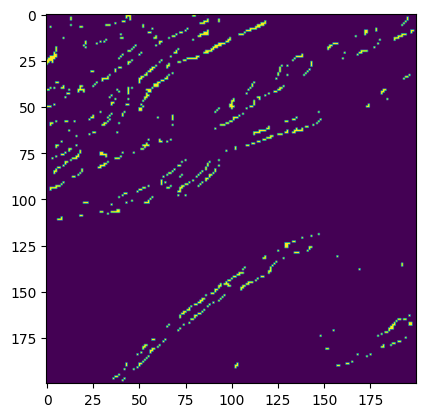

In [29]:
plt.imshow(surface[20])

The previous algorithm flagged some voxels as on-surface, but we actually want only the recto surface of every sheet -- the one on which text is written. To do so, we can just use the value of the gradient computed on each voxel flagged as on-surface and check that the dot product with a vector coming from the main axis of the scroll is positive. In this tutorial let's assume that this vector is just (0,-1,0).

In [30]:
vector = np.array([0,-1,0], dtype=np.float32)

In [31]:
_, gradient, _ = grad_and_det(chunk, np.float32)

/tmp/ipykernel_24667/2646966447.py:15: RuntimeWarning: invalid value encountered in true_divide
  return a/b


In [32]:
dot_product = np.einsum('xdhw,x->dhw', gradient, vector)

In [33]:
recto_chunk = surface & (dot_product > 0)

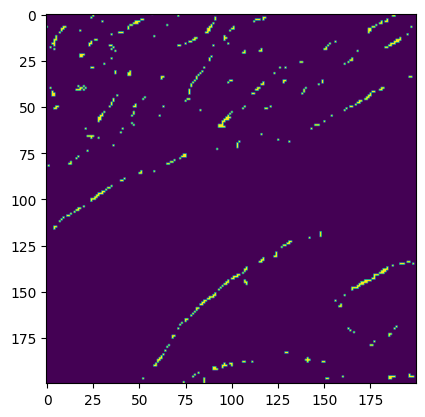

In [34]:
plt.imshow(recto_chunk[50])

**c. Layer extraction**
Let us extract a single layer / segment.





We install the library connected-components-3d that can help us cluster connected components of nearby flagged voxels in a 3D array.

In [ ]:
!pip install connected-components-3d
# or run
#!pip uninstall connected-components-3d -y
#!pip install connected-components-3d --no-binary :all:
import cc3d

In [ ]:
labels_out, N = cc3d.connected_components(recto_chunk, return_N=True)

In [ ]:
N

We extracted N different connected components 😞, let's focus on a big one!

In [ ]:
labels_out, N = cc3d.largest_k(
  recto_chunk, k=1,
  connectivity=26, delta=0,
  return_N=True,
)

In [ ]:
segment = labels_out == 1 # taking only the voxels corresponding to label (connected component) number 1

In [ ]:
plt.imshow(segment[0])

**d. Flattening**
we obtained a chunk with only some voxel on the recto surface of a sheet flagged as 1.
Now we are goint to convert it to a point cloud and flatten it. For simplicity we are going to do an orthographic projection since this is a small piece of surface with no much curvature.

In [ ]:
points = np.argwhere(segment == 1).astype(np.float32)

In [ ]:
flat_points = points[:,:-1]

In [ ]:
plt.scatter(flat_points[:,0],flat_points[:,1])

As you may notice, the projection has several holes and missing parts. This is because the algorithm to extract point cloud did not map those voxels as on-surface due to the imposed thresholding.

**e. Meshing**
In order to render this segment we need to build up the connectivity: we need to connect the dots. This means that we need to create a triangular mesh. We can do it on the flattened point cloud. Let us the class `Delaunay` to compute a Delaunay triangulation in 2D.

In [ ]:
from scipy.spatial import Delaunay
tri = Delaunay(flat_points)

In [ ]:
plt.triplot(flat_points[:,0], flat_points[:,1], tri.simplices)
plt.show()

Great! We have obtained an approximately decent triangular mesh! This mesh can translate the same connectivity to the 3D point cloud. This is possible because `tri.simplices` contains the indices of the points used as vertices of every triangle. But this is out of the scope of this tutorial!
